In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# import custom modules
from data.fetch_data import DataFetcher
from data.process_data import calculate_wind_speed, calculate_skiable_days, calculate_mean_anomalies

## Define locations and time duration

In [48]:
# Define locations and other parameters
locations = {
    "Glenshee": (56.875916, -3.377881),
    "Glencoe": (56.61286, -4.84884),
    "Cairngorm": (57.1187, -3.6542) 
}
start_date = '1950-01-01'
end_date = '2024-12-31'

## Fetch ERA5 data using google earth engine python api

In [ ]:
# Fetch and process data
skiable_data = {}
winter_anomalies = {}
for name, (lat, lon) in locations.items():
    # define the data fetcher
    fetcher = DataFetcher(lat, lon, start_date, end_date)

    # fetch the data variables
    snow_depth = fetcher.fetch_daily_variable('snow_depth')
    snowfall = fetcher.fetch_daily_variable('snowfall_sum')
    u_wind = fetcher.fetch_daily_variable('u_component_of_wind_10m')
    v_wind = fetcher.fetch_daily_variable('v_component_of_wind_10m')
    wind_speed = calculate_wind_speed(u_wind['u_component_of_wind_10m'], v_wind['v_component_of_wind_10m'])
    temperature = fetcher.fetch_daily_variable('temperature_2m')

    # calculate the anomalies
    snowfall_anomalies = calculate_mean_anomalies(snowfall['snowfall_sum'], baseline_start='1950-01-01', baseline_end='1979-12-31', annual=False)
    snow_depth_amomalies = calculate_mean_anomalies(snow_depth['snow_depth'], baseline_start='1950-01-01', baseline_end='1979-12-31', annual=False)
    temperature_anomalies = calculate_mean_anomalies(temperature['temperature_2m'], baseline_start='1950-01-01', baseline_end='1979-12-31', annual=False)

    # combine anomalies and add to dictionary
    winter_anomalies[name] = {
        'snowfall': snowfall_anomalies,
        'snow_depth': snow_depth_amomalies,
        'temperature': temperature_anomalies
    }

    skiable_days = calculate_skiable_days(snow_depth['snow_depth'], wind_speed, min_snow_depth=0.25, min_wind_speed=30)
    skiable_data[name] = skiable_days


## Plot winter anomalies

Calculating anomalies for Glenshee


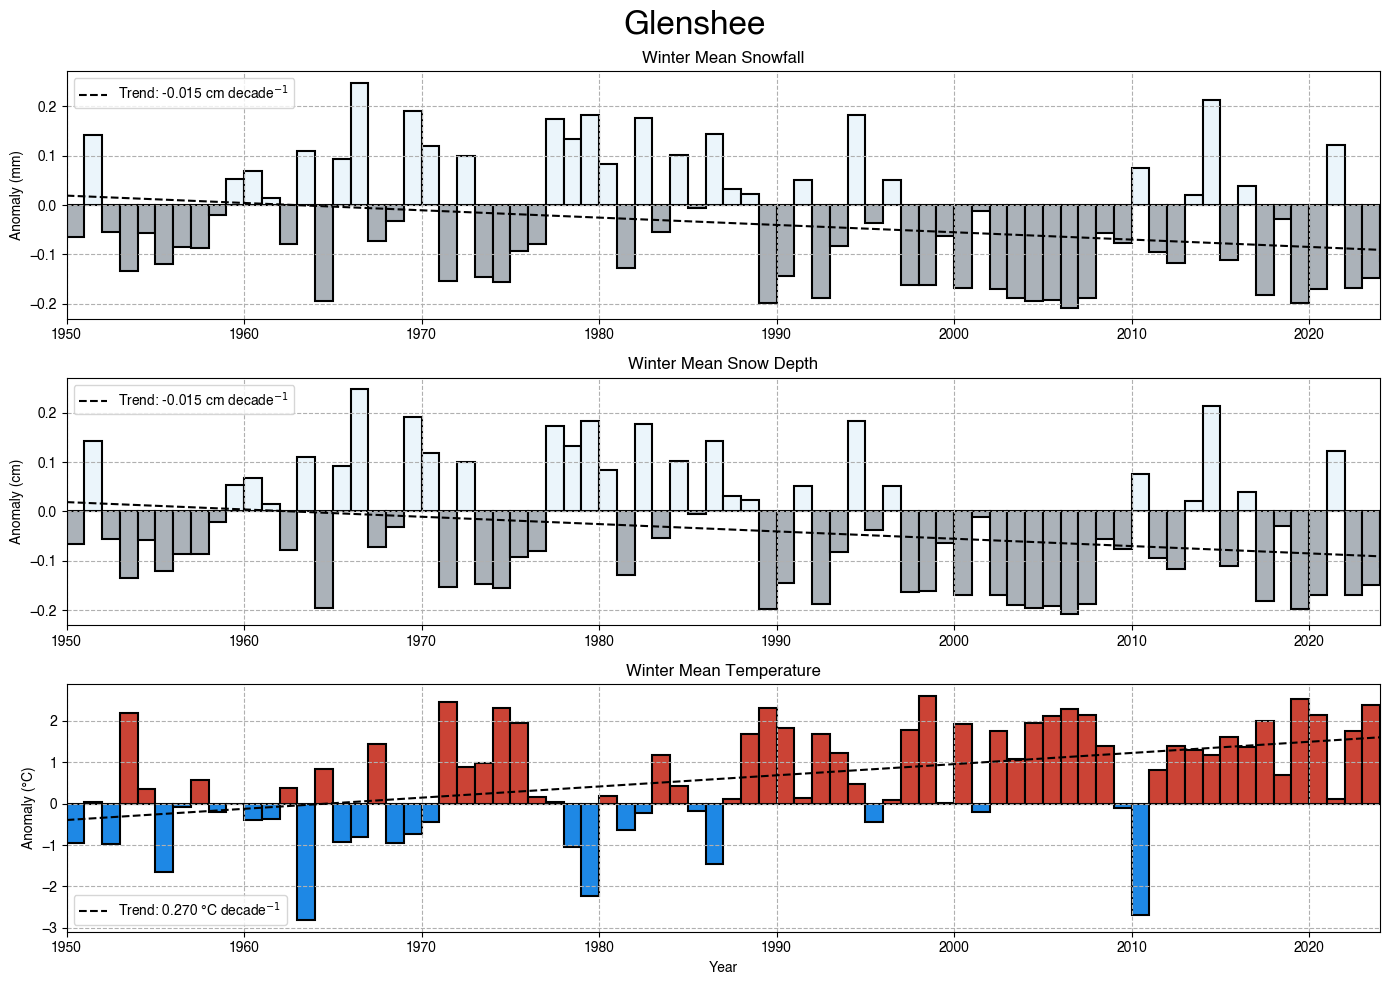

In [ ]:

# Define a function to add a trend line
def add_trend_line(ax, data, color):
    # Convert datetime index to numerical values (e.g., number of years since the first date)
    x = (data.index - data.index[0]).days / 365.25
    y = data.values.flatten()
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Plot the trend line using the original datetime index for the x-axis
    # calculate decade trend and units (e.g. degrees, m ,cm) to be added to the plot
    decade_trend = slope * 10
    units = 'mm' if 'snowfall' in data.name else 'cm' if 'snow_depth' in data.name else '°C'
    ax.plot(data.index, intercept + slope * x, color=color, label=fr'Trend: {decade_trend:.3f} {units} decade$^{{-1}}$', linestyle='--')
    ax.legend()

# Function to determine bar colors based on anomaly values
def get_bar_colors(data, positive_color, negative_color):
    return [positive_color if value >= 0 else negative_color for value in data]

for location, anomalies in winter_anomalies.items():
    print('Calculating anomalies for', location)

    # Extract the anomalies for each location
    snowfall_anom = winter_anomalies[location]['snowfall']
    snow_depth_anom = winter_anomalies[location]['snow_depth']
    air_temp_anom = winter_anomalies[location]['temperature']


    plt.rcParams['font.sans-serif'] = "Helvetica"
    plt.rcParams['font.family'] = "sans-serif"
    # Plotting each variable in a subplot using bar graphs
    fig, axs = plt.subplots(3, 1, figsize=(14, 10))
    bar_width = 365.0  # Set bar width to fill the entire year

    # Snowfall Anomalies Plot
    colors_snowfall = get_bar_colors(snowfall_anom, '#ebf5fb', '#abb2b9')    #           #ebf5fb  more snow,  #f39c12 
    axs[0].bar(snowfall_anom.index, snowfall_anom, color=colors_snowfall, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
    axs[0].set_title('Winter Mean Snowfall')
    axs[0].set_ylabel('Anomaly (mm)')
    axs[0].grid(True, linestyle='--')
    add_trend_line(axs[0], snowfall_anom, 'k')
    axs[0].set_xlim(snowfall_anom.index[0], snowfall_anom.index[-1])

    # Snow Depth Anomalies Plot
    colors_snow_depth = get_bar_colors(snow_depth_anom, '#ebf5fb', '#abb2b9')
    axs[1].bar(snow_depth_anom.index, snow_depth_anom, color=colors_snow_depth, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
    axs[1].set_title('Winter Mean Snow Depth')
    axs[1].set_ylabel('Anomaly (cm)')
    axs[1].grid(True, linestyle='--')
    add_trend_line(axs[1], snow_depth_anom, 'k')
    axs[1].set_xlim(snow_depth_anom.index[0], snow_depth_anom.index[-1])

    # Air Temperature Anomalies Plot
    colors_air_temp = get_bar_colors(air_temp_anom, '#cb4335', '#1e88e5')
    axs[2].bar(air_temp_anom.index, air_temp_anom, color=colors_air_temp, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
    axs[2].set_title('Winter Mean Temperature')
    axs[2].set_xlabel('Year')
    axs[2].set_ylabel('Anomaly (°C)')
    axs[2].grid(True, linestyle='--')
    add_trend_line(axs[2], air_temp_anom, 'k')
    axs[2].set_xlim(air_temp_anom.index[0], air_temp_anom.index[-1])

    # add figure title
    fig.suptitle(location, fontsize=24)

    plt.tight_layout()
    plt.show()


## Plot skiable days for different areas

Default: snow_depth > 0.25 m, and wind speed < 30 mph

IndexError: list index out of range

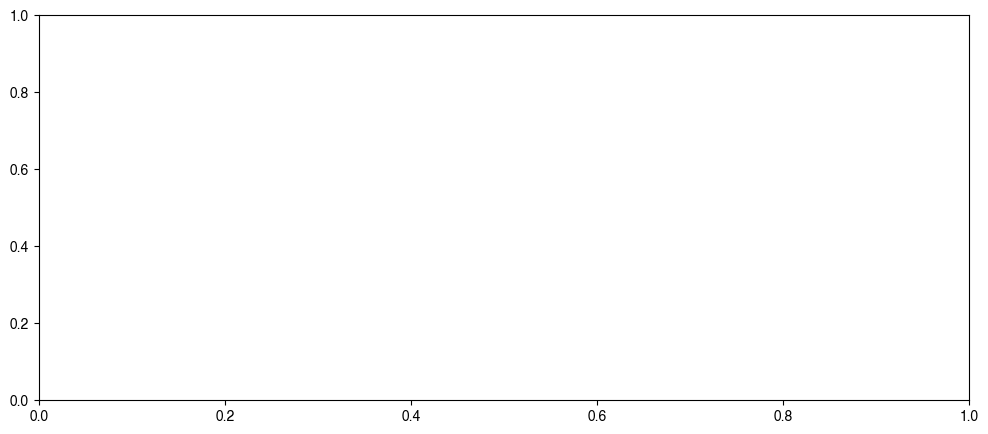

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['cornflowerblue', 'lightsteelblue', 'teal']
bottom = np.zeros(len(skiable_data[list(skiable_data.keys())[0]]))
for i, (name, data) in enumerate(skiable_data.items()):
    ax.bar(data.index.year, data, bottom=bottom, color=colors[i], label=f'{name}', edgecolor='black', linewidth=1.2, zorder=2)
    bottom += data.values

ax.set_ylabel('Total Skiable Days')
ax.legend()
ax.grid(True, linestyle='--', zorder=-4)
ax.set_title(r'Total Skiable Days per Year defined as $\bf{Snowdepth > 0.25m}$ and $\bf{Windspeed < 30mph}$')
plt.tight_layout()
plt.show()